<a href="https://colab.research.google.com/github/Telemachus19/02-24-00205-Machine-Learning/blob/main/Homework/HomeWork1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# day06: Gradient Descent for Linear Regression

# Objectives

* Learn how to fit weight parameters of Linear Regression to a simple dataset via gradient descent
* Understand impact of step size
* Understand impact of initialization


# Outline
* [Part 1: Loss and Gradient for 1-dim. Linear Regression](#part1)
* [Part 2: Gradient Descent Algorithm in a few lines of Python](#part2)
* [Part 3: Debugging with Trace Plots](#part3)
* [Part 4: Selecting the step size](#part4)
* [Part 5: Selecting the initialization](#part5)
* [Part 6: Using SciPy's built-in routines](#part6)

# Takeaways


* Gradient descent is a simple algorithm that can be implemented in a few lines of Python
    * Practical issues include selecting step size and initialization
* Step size matters a lot
    * Need to select carefully for each problem

* Initialization of the parameters can matter too!

* scipy offers some useful tools for gradient-based optimization
    * scipy's toolbox cannot do scalable "stochastic" methods (requires a modest size dataset, not too big)
    * "L-BFGS-B" method is highly recommended if you have your loss and gradient functions available


In [1]:
import numpy as np

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Create simple dataset:   y = 1.234 * x + noise

We will *intentionally* create a toy dataset where we know that a good solution has slope near 1.234.

Naturally, the best slope for the finite dataset of N=100 examples we create won't be exactly 1.234 (because of the noise added plus the fact that our dataset size is limited).

> `np.linspace(start,end,num)` 
> returns evenly space numbers over a specified interval [start,end]


In [3]:
def create_dataset(N=100, slope=1.234, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    # input features
    x_N = np.linspace(-2, 2, N)
    # linspsace(start,stop,num)
    # Return evenly spaced numbers over a specified interval.
    # Returns num evenly spaced samples, calculated over the interval [start, stop].
    # The endpoint of the interval can optionally be excluded.
    print("The x values range from -2 to 2")
    print('The x values genereated :\n',x_N)
    # output features
    y_N = slope * x_N + random_state.randn(N) * noise_stddev
    print("The y values generated : \n",y_N)
    
    return x_N, y_N

In [4]:
x_N, y_N = create_dataset(N=50, noise_stddev=0.3)

The x values range from -2 to 2
The x values genereated :
 [-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]
The y values generated : 
 [-1.9387843  -2.24721814 -1.97290922 -1.49352796 -1.50479383 -2.25750989
 -1.57856531 -1.80826431 -1.6930881  -1.4382082  -1.41743999 -0.92363632
 -1.03087236 -1.12194647 -0.92455532 -0.85687729 -0.40802118 -0.81705768
 -0.5608552  -0.81026954 -1.21920307 -0.15648585  0.00749412 -0.37375155
  0.63055904 

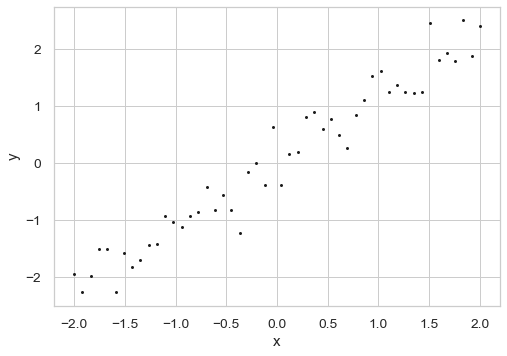

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x_N, y_N, 'k.');
plt.xlabel('x');
plt.ylabel('y');

# Part 1: Gradient Descent for 1-dim. Linear Regression

## Define model

Consider the *simplest* linear regression model. A single weight parameter $w \in \mathbb{R}$ representing the slope of the prediction line. No bias/intercept.

To make predictions, we just compute the weight multiplied by the input feature
$$
\hat{y}(x) = w \cdot x
$$

## Define loss function

We want to minimize the total *squared error* across all N observed data examples (input features $x_n$, output responses $y_n$)

\begin{align}
    \min_{w \in \mathbb{R}} ~~ &J(w)
    \\
    \text{calc_loss}(w) = J(w) &= \sum_{n=1}^N (y_n - w x_n)^2
\end{align}

### Exercise 1A: Complete the code below

You should make it match the math expression above.

In [6]:
def calc_loss(w):
    ''' Compute loss for slope-only least-squares linear regression
    
    Args
    ----
    w : float
        Value of slope parameter

    Returns
    -------
    loss : float
        Sum of squared error loss at provided w value
    '''
    y = y_N
    yhat_N = w * x_N
    sum_squared_error = np.sum(np.square(y-yhat_N))
    return sum_squared_error

# Define the gradient function

\begin{align}
\text{calc_grad}(w) = \ell'(w) &= \frac{\partial}{\partial w} [ \sum_{n=1}^N (y_n - w x_n)^2] 
\\
&= \sum_{n=1}^N 2 (y_n - w x_n) (-x_n)
\\
&= 2 \sum_{n=1}^N (w x_n - y_n) (x_n)
\\
&= 2  w \left( \sum_{n=1}^N x_n^2 \right) - 2 \sum_{n=1}^N y_n x_n
\end{align}

Below, we've implemented the gradient calculation in code for you

In [7]:
def calc_grad(w):
    ''' Compute gradient for slope-only least-squares linear regression
    
    Args
    ----
    w : float
        Value of slope parameter

    Returns
    -------
    g : float
        Value of derivative of loss function at provided w value
    '''
    g = 2.0 * w * np.sum(np.square(x_N)) - 2.0 * np.sum(x_N * y_N)
    calc_loss(g)
    return g

## Plot loss evaluated at each w from -3 to 8

We should see a "bowl" shape with one *global* minima, because our optimization problem is "convex"

In [8]:
w_grid = np.linspace(-3, 8, 300) # create array of 300 values between -3 and 8

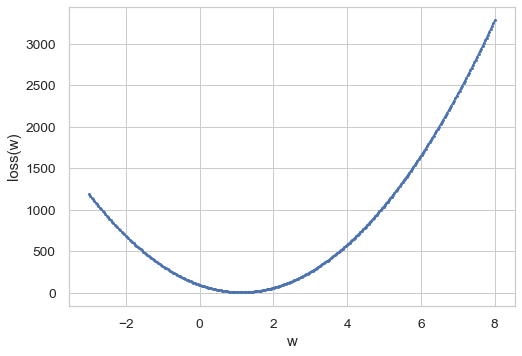

In [9]:
loss_grid = np.asarray([calc_loss(w) for w in w_grid])
plt.plot(w_grid, loss_grid, 'b.-');
plt.xlabel('w');
plt.ylabel('loss(w)');

### Discussion 1b: Visually, at what value of $w$ does the loss function have a minima? Is it near where you would expect (hint: look above for the "true" slope value used to generate the data)

Visually, the minimum appears to be around the value of 1 threshold, which is extremely near the true slope of the function.

### Exercise 1c: Write NumPy code to identify which entry in the w_grid array corresponds to the lowest entry in the loss_grid array

Hint: use np.argmin

In [10]:
# TODO write code here
# np.amin(loss_grid)
# np.amin(w_grid)
print(np.amin(a=loss_grid))
index = np.argmin(a=loss_grid)
print(w_grid[index])
print(calc_loss(w_grid[index]))

5.0159028192802575
1.120401337792643
5.0159028192802575


## Sanity check: plot gradient evaluated at each w from -3 to 8

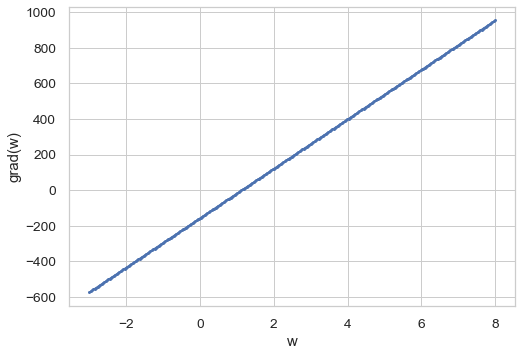

In [11]:
grad_grid = np.asarray([calc_grad(w) for w in w_grid])
plt.plot(w_grid, grad_grid, 'b.-');
plt.xlabel('w');
plt.ylabel('grad(w)');

### Discussion 1d: Visually, at what value of $w$ does the gradient function cross zero? Is it the same place as the location of the minimum in the loss above?

The gradient function cross the zero approximately around the same value we have previously estimated visually.

### Exercise 1d: Numerically, at which value of w does grad_grid cross zero?

We might try to estimate numerically where the gradient crosses zero.

We could do this in a few steps:

1) Compute the distance from each gradient in `grad_grid` to 0.0 (we could use just absolute distance)

2) Find the index of `grad_grid` with smallest distance (using `np.argmin`)

3) Plug that index into `w_grid` to get the $w$ value corresponding to that zero-crossing

In [12]:
dist_from_zero_G = np.abs(grad_grid - 0.0)

zero_cross_index =np.argmin(dist_from_zero_G) # TODO fix me for step 2 above

print("Zero crossing occurs at w = %.4f" % w_grid[zero_cross_index]) # TODO fix me for step 3 above

Zero crossing occurs at w = 1.1204


## Part 2: Gradient Descent (GD) as an algorithm in Python


### Define minimize_via_grad_descent algorithm

Can you understand what each step of this algorithm does?

In [13]:
def minimize_via_grad_descent(calc_loss, calc_grad, init_w=0.0, step_size=0.001, max_iters=100):
    ''' Perform minimization of provided loss function via gradient descent
    
    Args
    ----
    calc_loss : function
    calc_grad : function
    init_w : float
    step_size : float
    max_iters : positive int
    
    Return
    ----
    wopt: float
        array of optimized weights that approximately gives the least error
    info_dict : dict
        Contains information about the optimization procedure useful for debugging
        Entries include:
        * trace_loss_list : list of loss values
        * trace_grad_list : list of gradient values
    '''
    w = 1.0 * init_w 
    grad = calc_grad(w)

    # Create some lists to track progress over time (for debugging)
    trace_loss_list = []
    trace_w_list = []
    trace_grad_list = []

    for iter_id in range(max_iters):
        if iter_id > 0:
            w = w - step_size * grad
        
        loss = calc_loss(w)
        grad = calc_grad(w)    

        print("  iter %5d/%d | w  % 13.5f | loss % 13.4f | grad % 13.4f" % (
            iter_id, max_iters, w, loss, grad))
    
        trace_loss_list.append(loss)
        trace_w_list.append(w)
        trace_grad_list.append(grad)
    
    wopt = w
    info_dict = dict(
        trace_loss_list=trace_loss_list,
        trace_w_list=trace_w_list, 
        trace_grad_list=trace_grad_list)
    
    return wopt, info_dict

### Discussion 2a: Which line of the above function does the *parameter update* happen?

Remember, in math, the parameter update of gradient descent is this:
$$
w \gets w - \alpha \nabla_w \ell(w)
$$

where $\alpha > 0$ is the step size.

In words, this math says *move* the parameter $w$ from its current value a *small step* in the "downhill" direction (indicated by gradient).

`w = w - step_size * grad`

### Try it! Run GD with step_size = 0.001

Running the cell below will have the following effects:

1) one line will be printed for every iteration, indicating the current w value and its associated loss

2) the "optimal" value of w will be stored in the variable named `wopt` returned by this function

3) a dictionary of information useful for debugging will be stored in the `info_dict` returned by this function

In [14]:
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0.001,max_iters=200);

  iter     0/200 | w        0.00000 | loss       93.3197 | grad     -156.5566
  iter     1/200 | w        0.15656 | loss       70.5104 | grad     -134.8304
  iter     2/200 | w        0.29139 | loss       53.5926 | grad     -116.1192
  iter     3/200 | w        0.40751 | loss       41.0446 | grad     -100.0047
  iter     4/200 | w        0.50751 | loss       31.7376 | grad      -86.1265
  iter     5/200 | w        0.59364 | loss       24.8345 | grad      -74.1743
  iter     6/200 | w        0.66781 | loss       19.7144 | grad      -63.8807
  iter     7/200 | w        0.73169 | loss       15.9168 | grad      -55.0156
  iter     8/200 | w        0.78671 | loss       13.1001 | grad      -47.3808
  iter     9/200 | w        0.83409 | loss       11.0110 | grad      -40.8055
  iter    10/200 | w        0.87489 | loss        9.4614 | grad      -35.1427
  iter    11/200 | w        0.91004 | loss        8.3121 | grad      -30.2657
  iter    12/200 | w        0.94030 | loss        7.4597 | grad 

### Discussion 2b: Does it appear from the *loss* values in trace above that the GD procedure converged?

Observing the loss of each iterations, it can be easily determined that after 47 iteration, the loss value has not changed, hence it has converged.

### Discussion 2c: Does it appear from the *parameter* values in trace above that the GD procedure converged?

The same can be said that after 47 iterations that values have stabilized and not changed, where the gradient value is zero, loss stabilized at 5.0118, w at 1.12813. 
Hence, It appears from the parameter that it has converged

### Exercise 2d: What exactly is the gradient of the returned "optimal" value of w?

Use your `calc_grad` function to check the result. What is the gradient of the returned `wopt`?

Does this look totally converged? Can you find a $w$ value that would be even better?

In [15]:
calc_grad(wopt)# TODO call calc_grad on the return value from above

-1.921307557495311e-11

## Part 3: Diagnostic plots for gradient descent

Let's look at some trace functions.

Whenever you run gradient descent, an *excellent* debugging strategy is the ability to plot the loss, the gradient magnitude, and the parameter of interest at every step of the algorithm.

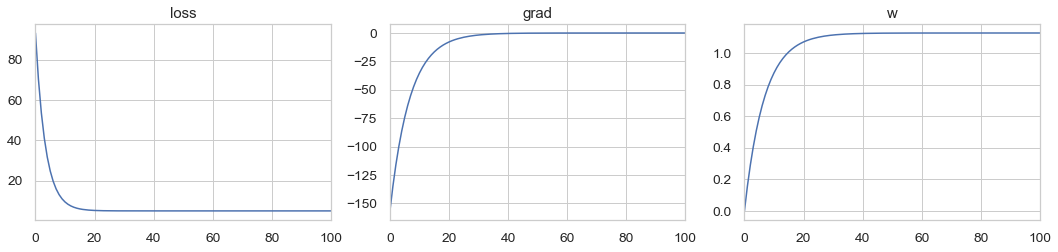

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(18,3.6))

axes[0].plot(info_dict['trace_loss_list']);
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list']);
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list']);
axes[2].set_title('w');

plt.xlim([0, 100]);

### Discussion 3a: What value do we expect the *loss* to converge to? Should it always be zero?

I don't expect that the value of the loss function to converge to zero since it can result in over-fitting producing erroneous results during validation.
Hence, It *shouldn't* be zero.

### Discussion 3b: What value do we expect the *gradient* to converge to? Should it always be zero?

I expect that the value of graident to be minimized, so gradient should be expected to reach zero, but it may not always reach zero.

# Part 4: Larger step sizes

## Try with larger step_size = 0.014

In [17]:
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0.014);

  iter     0/100 | w        0.00000 | loss       93.3197 | grad     -156.5566
  iter     1/100 | w        2.19179 | loss       83.5157 | grad      147.6105
  iter     2/100 | w        0.12525 | loss       74.8002 | grad     -139.1756
  iter     3/100 | w        2.07370 | loss       67.0522 | grad      131.2227
  iter     4/100 | w        0.23659 | loss       60.1645 | grad     -123.7243
  iter     5/100 | w        1.96873 | loss       54.0414 | grad      116.6543
  iter     6/100 | w        0.33557 | loss       48.5981 | grad     -109.9884
  iter     7/100 | w        1.87540 | loss       43.7591 | grad      103.7033
  iter     8/100 | w        0.42356 | loss       39.4574 | grad      -97.7774
  iter     9/100 | w        1.79244 | loss       35.6332 | grad       92.1901
  iter    10/100 | w        0.50178 | loss       32.2336 | grad      -86.9221
  iter    11/100 | w        1.71869 | loss       29.2114 | grad       81.9551
  iter    12/100 | w        0.57132 | loss       26.5248 | grad 

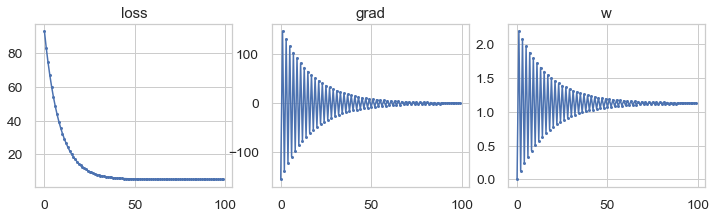

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss_list'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list'], '.-');
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list'], '.-');
axes[2].set_title('w');

### Discussion 4a: What happens here? How is this step size different than in Part 3 above?

By increasing the step size the loss function and gradient are oscillating which means if the step size is any larger it won't converge.

## Try with even larger step size 0.1

In [19]:
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0.1, max_iters=25);

  iter     0/25 | w        0.00000 | loss       93.3197 | grad     -156.5566
  iter     1/25 | w       15.65566 | loss    14649.2368 | grad     2016.0654
  iter     2/25 | w     -185.95088 | loss  2428476.1808 | grad   -25961.9847
  iter     3/25 | w     2410.24759 | loss  402716585.2503 | grad   334326.7829
  iter     4/25 | w   -31022.43070 | loss  66783022205.9171 | grad -4305310.2046
  iter     5/25 | w   399508.58976 | loss  11074716744084.4141 | grad  55441851.8184
  iter     6/25 | w  -5144676.59208 | loss  1836534899433323.2500 | grad -713955275.4570
  iter     7/25 | w   66250850.95363 | loss  304555007119229056.0000 | grad  9193995485.9874
  iter     8/25 | w  -853148697.64512 | loss  50504758929445773312.0000 | grad -118396145952.2056
  iter     9/25 | w   10986465897.57544 | loss  8375270853855496110080.0000 | grad  1524652410119.2183
  iter    10/25 | w  -141478775114.34641 | loss  1388882223424388487708672.0000 | grad -19633789199698.5000
  iter    11/25 | w   18219001448

### Discussion 3b: What happens here with this even larger step size? Is it converging?

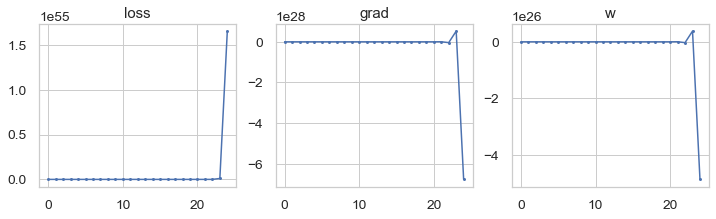

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss_list'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list'], '.-');
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list'], '.-');
axes[2].set_title('w');

As you can see from the figures above. Since the step size is large the values are oscilating meaning that we can't find the minimum in the gradient due to step size.
The loss is increasing while the gradient is going into the negative direction. Hence, It's not converging

### Exercise 3c: What is the largest step size you can get to converge reasonably?

In [21]:
# TODO try some other step sizes here
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0.0143) # TODO fix step_size

  iter     0/100 | w        0.00000 | loss       93.3197 | grad     -156.5566
  iter     1/100 | w        2.23876 | loss       90.6016 | grad      154.1284
  iter     2/100 | w        0.03472 | loss       87.9672 | grad     -151.7378
  iter     3/100 | w        2.20457 | loss       85.4138 | grad      149.3843
  iter     4/100 | w        0.06838 | loss       82.9391 | grad     -147.0673
  iter     5/100 | w        2.17144 | loss       80.5405 | grad      144.7863
  iter     6/100 | w        0.10100 | loss       78.2157 | grad     -142.5406
  iter     7/100 | w        2.13933 | loss       75.9625 | grad      140.3298
  iter     8/100 | w        0.13261 | loss       73.7786 | grad     -138.1532
  iter     9/100 | w        2.10820 | loss       71.6620 | grad      136.0105
  iter    10/100 | w        0.16325 | loss       69.6105 | grad     -133.9009
  iter    11/100 | w        2.07804 | loss       67.6222 | grad      131.8241
  iter    12/100 | w        0.19295 | loss       65.6950 | grad 

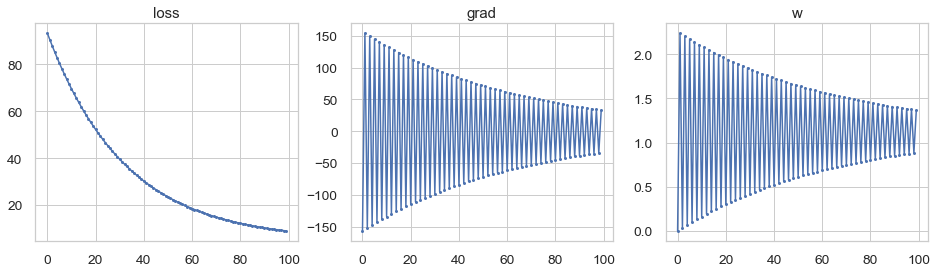

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(16,4))

axes[0].plot(info_dict['trace_loss_list'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list'], '.-');
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list'], '.-');
axes[2].set_title('w');

# Part 5: Sensitivity to initial conditions



### Exercise 5a: Try to call the defined procedure with a different initial condition for $w$. What happens?

You could try $w = 5.0$ or something else.

In [23]:
# TODO try some other initial condition for init_w
wopt2, info_dict2 = minimize_via_grad_descent(calc_loss, calc_grad, init_w=5, step_size=0.001) # TODO fix step_size

  iter     0/100 | w        5.00000 | loss     1045.2307 | grad      537.3210
  iter     1/100 | w        4.46268 | loss      776.5501 | grad      462.7540
  iter     2/100 | w        3.99993 | loss      577.2676 | grad      398.5351
  iter     3/100 | w        3.60139 | loss      429.4583 | grad      343.2282
  iter     4/100 | w        3.25816 | loss      319.8270 | grad      295.5965
  iter     5/100 | w        2.96257 | loss      238.5126 | grad      254.5749
  iter     6/100 | w        2.70799 | loss      178.2011 | grad      219.2462
  iter     7/100 | w        2.48874 | loss      133.4676 | grad      188.8202
  iter     8/100 | w        2.29992 | loss      100.2885 | grad      162.6166
  iter     9/100 | w        2.13731 | loss       75.6792 | grad      140.0494
  iter    10/100 | w        1.99726 | loss       57.4263 | grad      120.6139
  iter    11/100 | w        1.87664 | loss       43.8881 | grad      103.8757
  iter    12/100 | w        1.77277 | loss       33.8466 | grad 

### Exercise 5b: Try again with another initial value. 

In [24]:
# TODO try some other initial condition for init_w
wopt3, info_dict3 = minimize_via_grad_descent(calc_loss, calc_grad, init_w=1, step_size=0.001) # TODO fix

  iter     0/100 | w        1.00000 | loss        6.1509 | grad      -17.7811
  iter     1/100 | w        1.01778 | loss        5.8567 | grad      -15.3135
  iter     2/100 | w        1.03309 | loss        5.6384 | grad      -13.1884
  iter     3/100 | w        1.04628 | loss        5.4766 | grad      -11.3581
  iter     4/100 | w        1.05764 | loss        5.3565 | grad       -9.7819
  iter     5/100 | w        1.06742 | loss        5.2675 | grad       -8.4244
  iter     6/100 | w        1.07585 | loss        5.2014 | grad       -7.2553
  iter     7/100 | w        1.08310 | loss        5.1524 | grad       -6.2485
  iter     8/100 | w        1.08935 | loss        5.1161 | grad       -5.3813
  iter     9/100 | w        1.09473 | loss        5.0891 | grad       -4.6345
  iter    10/100 | w        1.09937 | loss        5.0692 | grad       -3.9914
  iter    11/100 | w        1.10336 | loss        5.0543 | grad       -3.4375
  iter    12/100 | w        1.10680 | loss        5.0433 | grad 

### Exercise 5c: Make a trace plot

Make a trace plot showing convergence from multiple different starting values for $w$. What do you notice?

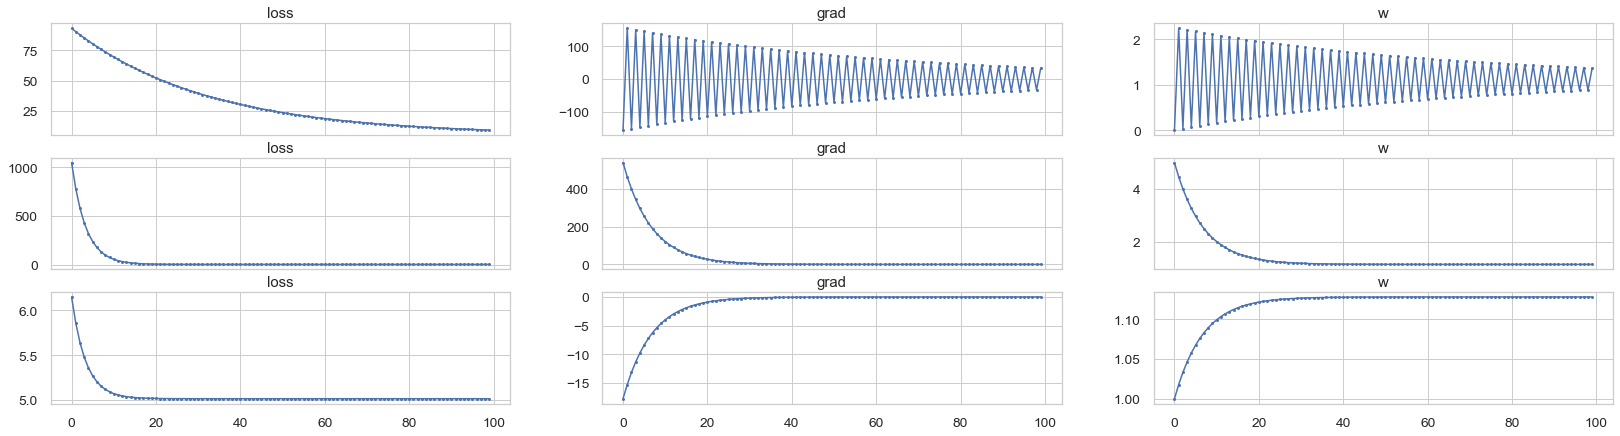

In [25]:
# TODO
fig, (axes1,axes2,axes3) = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False,figsize=(28,7))

axes1[0].plot(info_dict['trace_loss_list'], '.-');
axes1[0].set_title('loss');
axes1[1].plot(info_dict['trace_grad_list'], '.-');
axes1[1].set_title('grad');
axes1[2].plot(info_dict['trace_w_list'], '.-');
axes1[2].set_title('w');
axes2[0].plot(info_dict2['trace_loss_list'], '.-');
axes2[0].set_title('loss');
axes2[1].plot(info_dict2['trace_grad_list'], '.-');
axes2[1].set_title('grad');
axes2[2].plot(info_dict2['trace_w_list'], '.-');
axes2[2].set_title('w');
axes3[0].plot(info_dict3['trace_loss_list'], '.-');
axes3[0].set_title('loss');
axes3[1].plot(info_dict3['trace_grad_list'], '.-');
axes3[1].set_title('grad');
axes3[2].plot(info_dict3['trace_w_list'], '.-');
axes3[2].set_title('w');

# Part 6: Using scipy's built-in gradient optimization tools


In [26]:
import scipy.optimize

Take a look at SciPy's built in minimization toolbox

<https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize>

We'll use "L-BFGS", a second-order method that uses the function and its gradient.

This is a "quasi-newton" method, which you can get an intuition for here:

https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization

In [27]:
result = scipy.optimize.minimize(calc_loss, 0.0, jac=calc_grad, method='L-BFGS-B')

# Returns an object with several fields, let's print the result to get an idea
print(result)

      fun: 5.011759943825978
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.84217094e-14])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([1.12812831])


In [28]:
print(str(result.message))

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


In [29]:
best_w = result.x
print(best_w)

[1.12812831]
